# Chest X-Rays Medical Diagnosis
<img src="xray-header-image.png" style="width: 87%;left: 0px;margin-left: 0px;margin-right: 0px;">

## Exploratory Data Analysis

### Dataset
The Chest X-Rays dataset is retrieved from [Xiaosong Wang et al. *2017*, ChestX-ray8: Hospital-scale Chest X-ray Database and Benchmarks on Weakly-Supervised Classification and Localization of Common Thorax Diseases] at https://arxiv.org/abs/1705.02315.

### Author's notes

*The chest X-ray is one of the most commonly accessible
radiological examinations for screening and diagnosis
of many lung diseases. A tremendous number of X-ray
imaging studies accompanied by radiological reports are
accumulated and stored in many modern hospitals’ Picture
Archiving and Communication Systems (PACS).*

*ChestX-ray dataset comprises 112,120 frontal-view X-ray images of 30,805 unique patients with the text-mined fourteen disease image labels (where each image can have multi-labels), mined from the associated radiological reports using natural language processing. Fourteen common thoracic pathologies include Atelectasis, Consolidation, Infiltration, Pneumothorax, Edema, Emphysema, Fibrosis, Effusion, Pneumonia, Pleural_thickening, Cardiomegaly, Nodule, Mass and Hernia, which is an extension of the 8 common disease patterns listed in our CVPR2017 paper. Note that original radiology reports (associated with these chest x-ray studies) are not meant to be publicly shared for many reasons. The text-mined disease labels are expected to have accuracy >90%.*

### Import and explore

In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

We have prepared the training set, validation set, and test sets in pickle files. In the original dataset, only a development and a test sets are provided. We have therefore randomly assigned patients from the development set to a validation set (with probability of 0.15).

In [27]:
# loading labels for each set of X-rays
y_train = pd.read_pickle("y_train.pkl")
y_val = pd.read_pickle("y_val.pkl")
y_test = pd.read_pickle("y_test.pkl")

In [28]:
# getting info about the loaded dataframe
y_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73220 entries, 0 to 73219
Data columns (total 16 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Image               73220 non-null  object
 1   Atelectasis         73220 non-null  object
 2   Cardiomegaly        73220 non-null  object
 3   Consolidation       73220 non-null  object
 4   Edema               73220 non-null  object
 5   Effusion            73220 non-null  object
 6   Emphysema           73220 non-null  object
 7   Fibrosis            73220 non-null  object
 8   Hernia              73220 non-null  object
 9   Infiltration        73220 non-null  object
 10  Mass                73220 non-null  object
 11  Nodule              73220 non-null  object
 12  PatientId           73220 non-null  object
 13  Pleural_Thickening  73220 non-null  object
 14  Pneumonia           73220 non-null  object
 15  Pneumothorax        73220 non-null  object
dtypes: object(16)
memory u

In [29]:
# let's explore the first 5 examples
y_train.head()

,Image,Atelectasis,Cardiomegaly,Consolidation,Edema,Effusion,Emphysema,Fibrosis,Hernia,Infiltration,Mass,Nodule,PatientId,Pleural_Thickening,Pneumonia,Pneumothorax
0,00000002_000.png,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0
1,00000004_000.png,0,0,0,0,0,0,0,0,0,1,1,4,0,0,0
2,00000005_000.png,0,0,0,0,0,0,0,0,0,0,0,5,0,0,0
3,00000005_001.png,0,0,0,0,0,0,0,0,0,0,0,5,0,0,0
4,00000005_002.png,0,0,0,0,0,0,0,0,0,0,0,5,0,0,0


We notice how for images there are a few negative examples (labelled 0, i.e. they don't have the disease). Except from the column "PatientId", all are the target label that the model has to predict given the input X-ray file. The name of the X-ray file that needs to be fed to the Deep Learning algorithm for every example is stored in the "Image" column.

In really, there are so much X-ray images that there are stored per batch in multiple folders of max 4 GB. Storing training data into multiple folders, we cannot longer only specify the image name in the "Image" column. Instead, we need to add the folder path to the image filename. Hopefully, from one folder to another, images are stored by increasing patient id. We have manually identify the highest patient id per folder, so has to retrive the image absolute path.

In [30]:
# 12 folders = 12 steps. Here we identified the highest patient id per folder.
stp1 = 1335 # folder 1
stp2 = 3923 # folder 2
stp3 = 6585
stp4 = 9232 
stp5 = 11558 
stp6 = 13774
stp7 = 16051
stp8 = 18387
stp9 = 20945
stp10 = 24717
stp11 = 28173
stp12 = 30805

# define tuple of target dataframe to be processed to make absolute path
to_process = (y_train, y_val, y_test)

# list of steps 
stp_list = [0, stp1, stp2, stp3, stp4, stp5, stp6, stp7, stp8, stp9, stp10, stp11, stp12]

# every folder name
folder_names = ["images_001","images_002","images_003","images_004","images_005",\
                "images_006","images_007","images_008","images_009","images_010",\
                "images_011","images_012"]

def slice_df(df, low_bound, up_bound, parent_dir, child_dir):
    """ Adds the full path of a folder to each image in slice of the target dataframe
    
    Args:
        - df (dataframe): target labels with "Image" column storing image filename, 
                            "PatientId" column.
        - low_bound (int): lowest patient id in the given folder
        - up_bound (int): highest patient id in the given folder
        - parent_dir (str): directory where image folder are stored
        - child_dir (str): name of the given folder considered
    """
    
    # create a mask for image within that folder
    mask = (df.PatientId>low_bound) & (df.PatientId<=up_bound)
    
    # for these patients whose Id is between the low and upper bound, append
    # the image folder name.
    df.loc[mask, "Image"] = parent_dir + child_dir + "/" + df[mask]["Image"].astype(str)
    
    return df

def make_absolute_path(to_process, stp_list, parent_dir, folder_names):
    """
        Process dataframe and add folder names that correspond to the correct stp_list
        
    Args:
        - to_process (tuple): contains, y_train, y_val, y_test dataframe
        - stp_list (list): list of folder patient id bounds
        - parent_dir (string): name of the parent directory
        - folder_names (list): list of folder names
    """
    processed = []
    for df in to_process: # for all dataframe to be processed
        for i in range(len(folder_names)): # for all folders containing images
            
            low_bound = stp_list[i] # retrieve low bound
            up_bound = stp_list[i+1] # retrieve upper bound
            child_dir = folder_names[i] # retrieve the folder directory
            df = slice_df(df, low_bound, up_bound, parent_dir, child_dir) # apply slice_df
            # to rename "Image" with absolute path
        
        # append the processed dataframe to the list of processed dataframe
        processed.append(df)
    
    return processed

In [31]:
image_dir = '/Users/patrickfleith/Desktop/Projects/CXR/'
[y_train, y_val, y_test] = make_absolute_path(to_process,stp_list, image_dir, folder_names)

In [32]:
# example
y_train.loc[1000,"Image"]

'/Users/patrickfleith/Desktop/Projects/CXR/images_001/00000422_003.png'

In [33]:
y_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73220 entries, 0 to 73219
Data columns (total 16 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Image               73220 non-null  object
 1   Atelectasis         73220 non-null  object
 2   Cardiomegaly        73220 non-null  object
 3   Consolidation       73220 non-null  object
 4   Edema               73220 non-null  object
 5   Effusion            73220 non-null  object
 6   Emphysema           73220 non-null  object
 7   Fibrosis            73220 non-null  object
 8   Hernia              73220 non-null  object
 9   Infiltration        73220 non-null  object
 10  Mass                73220 non-null  object
 11  Nodule              73220 non-null  object
 12  PatientId           73220 non-null  object
 13  Pleural_Thickening  73220 non-null  object
 14  Pneumonia           73220 non-null  object
 15  Pneumothorax        73220 non-null  object
dtypes: object(16)
memory u

We can see that columns elements for each disease are of type object. This is not ideal as we would like to have float or integers that represent the 0/1 labels. We therefore convert the columns types into floats.

In [34]:
# columns to be converted into float objects
col_conv = y_train.columns.to_list()[1:]

# for each column, convert into float
for col in col_conv:
    y_train.loc[:,col]=y_train.loc[:,col].astype(np.float32)
    y_val.loc[:,col]=y_val.loc[:,col_conv].astype(np.float32)
    y_test.loc[:,col]=y_test.loc[:,col].astype(np.float32)

In [35]:
# now, all disease columns should contains floats
y_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73220 entries, 0 to 73219
Data columns (total 16 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Image               73220 non-null  object 
 1   Atelectasis         73220 non-null  float32
 2   Cardiomegaly        73220 non-null  float32
 3   Consolidation       73220 non-null  float32
 4   Edema               73220 non-null  float32
 5   Effusion            73220 non-null  float32
 6   Emphysema           73220 non-null  float32
 7   Fibrosis            73220 non-null  float32
 8   Hernia              73220 non-null  float32
 9   Infiltration        73220 non-null  float32
 10  Mass                73220 non-null  float32
 11  Nodule              73220 non-null  float32
 12  PatientId           73220 non-null  float32
 13  Pleural_Thickening  73220 non-null  float32
 14  Pneumonia           73220 non-null  float32
 15  Pneumothorax        73220 non-null  float32
dtypes: f

In [36]:
# let's have a look at the first and last 5 entries of the train dataframe
y_train.tail()

,Image,Atelectasis,Cardiomegaly,Consolidation,Edema,Effusion,Emphysema,Fibrosis,Hernia,Infiltration,Mass,Nodule,PatientId,Pleural_Thickening,Pneumonia,Pneumothorax
73215,/Users/patrickfleith/Desktop/Projects/CXR/imag...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,30786.0,0.0,0.0,0.0
73216,/Users/patrickfleith/Desktop/Projects/CXR/imag...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,30786.0,1.0,0.0,0.0
73217,/Users/patrickfleith/Desktop/Projects/CXR/imag...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,30789.0,0.0,0.0,0.0
73218,/Users/patrickfleith/Desktop/Projects/CXR/imag...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,30801.0,0.0,0.0,0.0
73219,/Users/patrickfleith/Desktop/Projects/CXR/imag...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,30801.0,0.0,1.0,0.0


In [37]:
# let's print shapes
print("shape of y_train:",y_train.shape)
print("shape of y_val:",y_val.shape)
print("shape of y_test:",y_test.shape)

# the total number of example is the sum of the length of all Y_xxx dataframes
tot = y_train.shape[0]+y_val.shape[0]+y_test.shape[0]

# let's compute the fraction of examples in each set
frac_train = y_train.shape[0]/tot
frac_val = y_val.shape[0]/tot
frac_test = y_test.shape[0]/tot

print("\n")
print("Total number of X-rays images in the original dataset:",tot)
print("Fraction of images in train set is",round(frac_train,4))
print("Fraction of images in validation set is",round(frac_val,4))
print("Fraction of images in test set is",round(frac_test,4))

shape of y_train: (73220, 16)
shape of y_val: (13304, 16)
shape of y_test: (25596, 16)


Total number of X-rays images in the original dataset: 112120
Fraction of images in train set is 0.6531
Fraction of images in validation set is 0.1187
Fraction of images in test set is 0.2283


### Important note:
We notice the large number of images. Indeed, downloading the entire dataset takes approximately 45 GB. Training the neural network on the entire dataset on a CPU took approximately 8 hours per epoch.

We have chosen to train the model for only over 10 epochs (80 hours) over a weekend.

In [38]:
# for demonstration purpose, it is possible to train on a subset of dataset.
#y_train_small = y_train[y_train.PatientId<=209]
#y_val_small = y_val[y_val.PatientId<=209]
#y_test_small = y_test[y_test.PatientId<=209]

# we do not reduce the dataset when training
y_train_small = y_train
y_val_small = y_val
y_test_small = y_test

In [39]:
y_train_small.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73220 entries, 0 to 73219
Data columns (total 16 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Image               73220 non-null  object 
 1   Atelectasis         73220 non-null  float32
 2   Cardiomegaly        73220 non-null  float32
 3   Consolidation       73220 non-null  float32
 4   Edema               73220 non-null  float32
 5   Effusion            73220 non-null  float32
 6   Emphysema           73220 non-null  float32
 7   Fibrosis            73220 non-null  float32
 8   Hernia              73220 non-null  float32
 9   Infiltration        73220 non-null  float32
 10  Mass                73220 non-null  float32
 11  Nodule              73220 non-null  float32
 12  PatientId           73220 non-null  float32
 13  Pleural_Thickening  73220 non-null  float32
 14  Pneumonia           73220 non-null  float32
 15  Pneumothorax        73220 non-null  float32
dtypes: f

In [40]:
# let's print shapes
print("shape of y_train_small:",y_train_small.shape)
print("shape of y_val_small:",y_val_small.shape)
print("shape of y_test_small:",y_test_small.shape)

tot_small = y_train_small.shape[0]+y_val_small.shape[0]+y_test_small.shape[0]
frac_train_small = y_train_small.shape[0]/tot_small
frac_val_small = y_val_small.shape[0]/tot_small
frac_test_small = y_test_small.shape[0]/tot_small

print("\n")
print("Total number of X-rays images in the reduced dataset:",tot_small)
print("Fraction of images in train set is",round(frac_train_small,4))
print("Fraction of images in validation set is",round(frac_val_small,4))
print("Fraction of images in test set is",round(frac_test_small,4))

shape of y_train_small: (73220, 16)
shape of y_val_small: (13304, 16)
shape of y_test_small: (25596, 16)


Total number of X-rays images in the reduced dataset: 112120
Fraction of images in train set is 0.6531
Fraction of images in validation set is 0.1187
Fraction of images in test set is 0.2283


Here we see that the set used for training over 10 epochs not reduced (same size than the original dataset (see above)).

### Preventing Data Leakage
It is worth mentionning that there more images than unique patient ids. This happens because a unique patient may have done an X-ray scan multiple times in his medical records, which compiles the images collected during its many visists to the hospital.

We have splitted our images between the train, validation, and test set, on a patient level so that there are no data patient data "leakage" between train, validation and test sets. To verify this fact, we are using the following function.

In [41]:
def check_for_leakage(df1, df2, patient_col):
    """Returns True if there is data leakage, returns False otherwise
    Args:
        df1 (dataframe): the first dataset
        df2 (dataframe): the second dataset
        patient_col (str): string name of the unique patient column IDs
    Returns:
        leakage (bool): True if there is leakage, otherwise False
    """
    
    df1_patients_unique = set(df1[patient_col].values)
    df2_patients_unique = set(df2[patient_col].values)
    patients_in_both_groups = list(df1_patients_unique.intersection(df2_patients_unique))
    
    if len(patients_in_both_groups)>=1:
        leakage = True 
    else:
        leakage = False
    
    return leakage

In [42]:
# let's check data leakage
print("leakage between train and test: {}".format(check_for_leakage(y_train_small, y_test_small, 'PatientId')))
print("leakage between valid and test: {}".format(check_for_leakage(y_train_small, y_val_small, 'PatientId')))

leakage between train and test: False
leakage between valid and test: False


In [43]:
print("number of unique patients in train set: {}"\
      .format(len(y_train_small.PatientId.unique())))
print("number of unique patients in validation set: {}"\
      .format(len(y_val_small.PatientId.unique())))
print("number of unique patients in test set: {}"\
      .format(len(y_test_small.PatientId.unique())))

number of unique patients in train set: 23806
number of unique patients in validation set: 4202
number of unique patients in test set: 2797


### Image Preparation & Generators
Due to the large volume of images in this Chest X-Rays dataset, the proposed way to feed the model during the training phase will be to use [ImageDataGenerator](https://keras.io/preprocessing/image/) class from the Keras framework, which allows us to build a "generator" for images specified in a dataframe. Advantages of this class are the following: data augmented images can be generated automatically, automatic standardization of the inputed image, resize inputed image, adjust the number of input channels, shuffle image feeding order before runing each epoch.

In [44]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K

from tensorflow.keras.models import load_model

In [45]:
def get_train_generator(df, image_dir, x_col, y_cols, shuffle=True, batch_size=8, seed=1, target_w = 320, target_h = 320):
    """
    Return generator for training set, normalizing using batch
    statistics.

    Args:
      train_df (dataframe): dataframe specifying training data.
      image_dir (str): directory where image files are held.
      x_col (str): name of column in df that holds filenames.
      y_cols (list): list of strings that hold y labels for images.
      batch_size (int): images per batch to be fed into model during training.
      seed (int): random seed.
      target_w (int): final width of input images.
      target_h (int): final height of input images.
    
    Returns:
        train_generator (DataFrameIterator): iterator over training set
    """
    
    # image normalisation
    image_generator = ImageDataGenerator(
        samplewise_center=True, # Set each sample mean to 0.
        samplewise_std_normalization=True) # Divide each input by its std.
    
    # flow from directory with specified batch size and target image size
    train_generator = image_generator.flow_from_dataframe(
            dataframe=df,
            directory=None,
            x_col=x_col,
            y_col=y_cols,
            class_mode="raw",
            batch_size=batch_size,
            shuffle=shuffle,
            seed=seed,
            target_size=(target_w,target_h))
    
    return train_generator

Now we also need to define a val_generator and test_generator for the test set. Why can't we use the same generator? This is because the train_generator normalizes each image per batch. We should not do that with validation and test data because in real-world scenarios incoming images won't be processed by batch but one at a time. Also, the model should not see any information about the test data at training time. Therefore, we will normalise the test images fed to the model using the statistics computed from the training set.

Practical note: computing the mean and stv over the 45 GB of images from the original dataset would take a lot of time. Hence, we take a random sample of the dataset and calculate the sample mean and sample standard deviation.


We should not do this with the test and validation data, since in a real life scenario we don't process incoming images one batch at a time (we process one image at a time).
Knowing the average per batch of test data would effectively give our model an advantage.
The model should not have any information about the test data.
What we need to do is normalize incoming test data using the statistics computed from the training set.

In [46]:
def get_test_generator(df_val, df_test, df_train, image_dir, x_col, y_cols, \
                       sample_size=100, batch_size=8, seed=1, target_w = 320, target_h = 320):
    """
    Return generator for validation set and test test set using 
    normalization statistics from training set.

    Args:
      valid_df (dataframe): dataframe specifying validation data.
      test_df (dataframe): dataframe specifying test data.
      train_df (dataframe): dataframe specifying training data.
      image_dir (str): directory where image files are held.
      x_col (str): name of column in df that holds filenames.
      y_cols (list): list of strings that hold y labels for images.
      sample_size (int): size of sample to use for normalization statistics.
      batch_size (int): images per batch to be fed into model during training.
      seed (int): random seed.
      target_w (int): final width of input images.
      target_h (int): final height of input images.
    
    Returns:
        test_generator (DataFrameIterator) and valid_generator: iterators over test set and validation set respectively
    """
    # get generator to sample dataset
    raw_train_generator = ImageDataGenerator().flow_from_dataframe(
        dataframe=df_train, 
        directory=None, 
        x_col="Image", 
        y_col=y_cols, 
        class_mode="raw", 
        batch_size=sample_size, 
        shuffle=True, 
        target_size=(target_w, target_h))
    
    # get data sample
    batch = raw_train_generator.next()
    data_sample = batch[0]

    # use sample to fit mean and std for test set generator
    image_generator = ImageDataGenerator(
        featurewise_center = True,
        featurewise_std_normalization = True)
    
    # fit generator to sample from training data
    image_generator.fit(data_sample)

    # get test generator
    val_generator = image_generator.flow_from_dataframe(
            dataframe=df_val,
            directory=None,
            x_col=x_col,
            y_col=y_cols,
            class_mode="raw",
            batch_size=batch_size,
            shuffle=False,
            seed=seed,
            target_size=(target_w,target_h))

    test_generator = image_generator.flow_from_dataframe(
            dataframe=df_test,
            directory=None,
            x_col=x_col,
            y_col=y_cols,
            class_mode="raw",
            batch_size=batch_size,
            shuffle=False,
            seed=seed,
            target_size=(target_w,target_h))
    return val_generator, test_generator

In [47]:
image_dir

'/Users/patrickfleith/Desktop/Projects/CXR/'

In [48]:
# specify columns with image filenames
x_col = "Image"

# specify dataframe columns with classe's labels
y_cols = ['Atelectasis',
          'Cardiomegaly',
          'Consolidation',
          'Edema',
          'Effusion',
          'Emphysema',
          'Fibrosis',
          'Hernia', 
          'Infiltration', 
          'Mass', 
          'Nodule',
          'Pleural_Thickening',
          'Pneumonia',
          'Pneumothorax']

# test train_generator and test_generator on the subset of the original datase
train_gen = get_train_generator(y_train_small, image_dir, x_col, y_cols, shuffle=True, \
                batch_size=64, seed=1, target_w = 320, target_h = 320)

val_gen, test_gen = get_test_generator(y_val_small, y_test_small, y_train_small, \
                image_dir, x_col, y_cols, sample_size=100, batch_size=64, seed=1, \
                   target_w = 320, target_h = 320)

/opt/anaconda3/lib/python3.8/site-packages/keras_preprocessing/image/dataframe_iterator.py:279: UserWarning: Found 1 invalid image filename(s) in x_col="Image". These filename(s) will be ignored.
  warnings.warn(


Found 73219 validated image filenames.
Found 73219 validated image filenames.
Found 13304 validated image filenames.
Found 25596 validated image filenames.


We can see that run the generators has succesffuly found the images (only 1 invalid image). Let's look at some X-rays at random.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


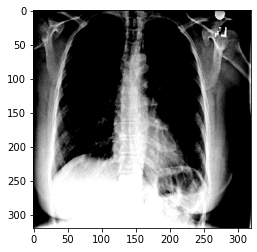

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


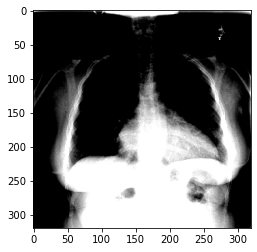

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


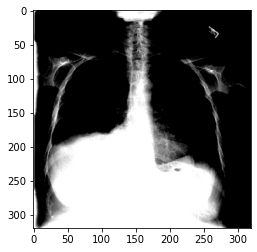

In [49]:
# randomly look at 3 images in the y_train_small set
for i in range(3):
    item = np.random.randint(y_train_small.shape[0])
    x, y = train_gen.__getitem__(i)
    plt.imshow(x[0])
    plt.show()

### Class Imbalance
In this section, we define a function to count the number of positive example per class in each dataset. As we can see, there is a large class imbalance. This is a key common challenge in most medical diagnostic datasets.

In [50]:
def count_pos_per_class(df):
    """Print out the number of positive labels for each class"""
    
    for col in df.drop(["Image","PatientId"], axis=1).columns:
        print(f"There are {df[col].sum()} positive examples of {col}")

In [51]:
print("\n Train Set:")
count_pos_per_class(y_train_small)

print("\n Validation Set:")
count_pos_per_class(y_val_small)

print("\n Test Set:")
count_pos_per_class(y_test_small)


 Train Set:
There are 7000.0 positive examples of Atelectasis
There are 1428.0 positive examples of Cardiomegaly
There are 2394.0 positive examples of Consolidation
There are 1117.0 positive examples of Edema
There are 7297.0 positive examples of Effusion
There are 1211.0 positive examples of Emphysema
There are 1045.0 positive examples of Fibrosis
There are 111.0 positive examples of Hernia
There are 11585.0 positive examples of Infiltration
There are 3416.0 positive examples of Mass
There are 3970.0 positive examples of Nodule
There are 1874.0 positive examples of Pleural_Thickening
There are 732.0 positive examples of Pneumonia
There are 2233.0 positive examples of Pneumothorax

 Validation Set:
There are 1280.0 positive examples of Atelectasis
There are 279.0 positive examples of Cardiomegaly
There are 458.0 positive examples of Consolidation
There are 261.0 positive examples of Edema
There are 1362.0 positive examples of Effusion
There are 212.0 positive examples of Emphysema
The

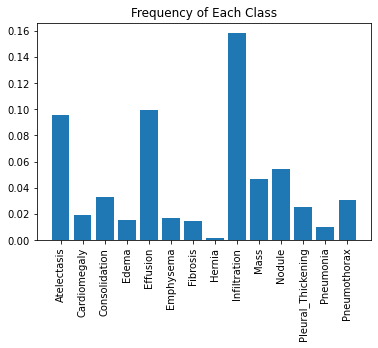

In [115]:
# visualising class imbalance
plt.xticks(rotation=90)
plt.bar(x=y_cols, height=np.mean(train_gen.labels, axis=0))
plt.title("Frequency of Each Class")
plt.show()

From this plot we see that most examples are negatives, and that the prevalence of positive cases varies significantly accross the different pathologies. This is an issue because a learning algorithm using a normal cross-entropy loss function may be incentivized to prioritise the majority class.
- Hernia has a very low frequency
- Even infiltration which is the most common pathology has only a frequency of about 14%.
This class imbalance issue is a key challenge for many medical diagnostic dataset, and we will demonstrate one way to deal with it.

Typically we can attribute different weights for each pathologies depending on its occurence frequency within the population. The weights in the loss function would typically be higher for the under-represented classes.

To do so, we use a weighted cross entropy loss defined as:

$$\mathcal{L}_{cross-entropy}^{weighted} = - (w_{p}*y_{true} \log(y_{pred}) + w_{n}*(1-y_{true}) \log( 1 - y_{pred} ) ).$$

we want the contributions to be equal. One way of doing this is by multiplying each example from each class by a class-specific weight factor, $w_{p}$ and $w_{n}$, so that the overall contribution of each class is the same. 

To have this, we want 

$$w_{p} \times f_{pos} = w_{n} \times f_{neg},$$

which we can do simply by taking 


$$w_{p} = f_{neg}$$
$$w_{n} = f_{pos}$$

and

$$f_{pos} = \frac{\text{number of positive examples}}{N} $$

$$\text{and}$$

$$f_{neg} = \frac{\text{number of negative examples}}{N}.$$

In [52]:
def class_frequencies(labels):
    """Computes the frequency of positive and negative label per class
    Args:
        labels (numpy array): num_examples x num_classes
    Returns:
        freq_pos (np array): frequency of positive examples (num_class,)
        freq_neg (np array): frequency of negative examples (num_class,)
    """
    # total number of patients (rows)
    N = labels.shape[0]
    
    positive_freq = np.sum(labels==1, axis=0)/N
    negative_freq = np.sum(labels==0, axis=0)/N

    ### END CODE HERE ###
    return positive_freq, negative_freq

In [53]:
# Test
labels_matrix = np.array(
    [[1, 0, 0],
     [0, 1, 1],
     [1, 0, 1],
     [1, 1, 1],
     [1, 0, 1]]
)
print("labels:")
print(labels_matrix)

test_pos_freqs, test_neg_freqs = class_frequencies(labels_matrix)

print(f"pos freqs: {test_pos_freqs}")

print(f"neg freqs: {test_neg_freqs}")

labels:
[[1 0 0]
 [0 1 1]
 [1 0 1]
 [1 1 1]
 [1 0 1]]
pos freqs: [0.8 0.4 0.8]
neg freqs: [0.2 0.6 0.2]


In [54]:
freq_pos, freq_neg = class_frequencies(train_gen.labels)
print(freq_pos)

[0.0956036  0.01950313 0.03269643 0.0152556  0.09965992 0.01653942
 0.01427225 0.001516   0.15822396 0.04665456 0.0542209  0.02559445
 0.00999741 0.03049755]


In [55]:
pos_weights = freq_neg
neg_weights = freq_pos


pos_contribution = freq_pos * pos_weights
neg_contribution = freq_neg * neg_weights

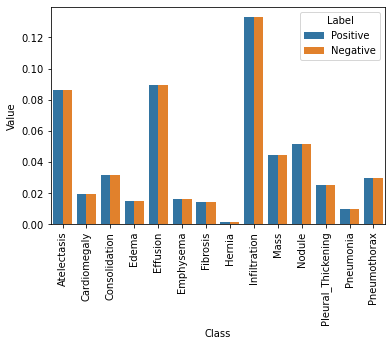

In [56]:
data = pd.DataFrame({"Class": y_cols, "Label": "Positive", "Value": pos_contribution})
data = data.append([{"Class": y_cols[l], "Label": "Negative", "Value": v} 
                        for l,v in enumerate(neg_contribution)], ignore_index=True)
plt.xticks(rotation=90)
f = sns.barplot(x="Class", y="Value", hue="Label" ,data=data)

Applying these weights to the positives and negatives examples during training, we would have the same aggregated contribution to the loss function.

It is now time to implement the custom weight function using those weights. Recall that:
$$\mathcal{L}_{cross-entropy}^{weighted} = - (w_{p}*y_{true} \log(y_{pred}) + w_{n}*(1-y_{true}) \log( 1 - y_{pred} ) ).$$

In [79]:
# Let's now define a function that returns the wegithed loss function
def get_weighted_loss_function(pos_weights, neg_weights, epsilon=1e-7):
    """Returns a weighted loss function"""
    def weighted_loss(y_true, y_pred):
        
        # we initialize loss to zero
        loss = 0.0

        for i in range(len(pos_weights)):
            # for each class, add average weighted loss for that class 
            loss += -(pos_weights[i]*K.mean(y_true[:,i]*K.log(epsilon + y_pred[:,i])) + \
                      neg_weights[i]*K.mean((1-y_true[:,i])*(K.log(epsilon+1-y_pred[:,i]))))
        return loss
    
    return weighted_loss

## Modelling

We used a pre-trained DenseNet model for image classification. The DenseNet model is a deep convolutional neural network where each layer is connected to all subsequent layers. Layer 2 is connected to layer 3, 4, 5, etc... Layer 3 is connected to layers 4, 5, 6, etc.
<img src="densenet.png"/>
For more details on this network, please refers to the original paper from Gao Huang et al. 2018: [Densely Connected Convolutional Networks](https://arxiv.org/pdf/1608.06993.pdf)

Quoting the authors: *For each layer, the feature-maps of all preceding layers are used as inputs, and its own feature-maps are used as inputs into all subsequent layers. DenseNets have several compelling advantages: they alleviate the vanishing-gradient problem, strengthen feature propagation, encourage feature reuse, and substantially reduce the number of parameters*

Fortuneately, Keras framework provides an implementation of DenseNet that we can readily use.

In [ ]:
from tensorflow.keras.applications.densenet import DenseNet121

# create the base pre-trained model
base_model = DenseNet121(weights='densenet.hdf5', include_top=False)

# Print the model summary
#base_model.summary()

There are a few ways we can explore the DenseNet architecture, below a few lines of code to do so.

In [63]:
# some LOC to explore the model (optional)
some_layers = base_model.layers

In [64]:
# look at the first 5 layers
print("First 5 layers")
some_layers[0:5]

First 5 layers


In [65]:
print("Last 5 layers")
some_layers[-6:-1]

Last 5 layers


In [66]:
# Get the convolutional layers and print the first 5
conv2D_layers = [layer for layer in base_model.layers 
                if str(type(layer)).find('Conv2D') > -1]
print("The first five conv2D layers")
conv2D_layers[0:5]

The first five conv2D layers


In [67]:
# counts the number of convulutional layers
print(f"There are {len(conv2D_layers)} convolutional layers")

There are 120 convolutional layers


In [68]:
# Print the number of channels in the input
print(f"There are {base_model.input.shape[3]} input channels")

There are 3 input channels


In [69]:
# Print the number of output channels
x = base_model.output
print(f"The output has {x.shape[3]} output channels")

The output has 1024 output channels


### Model adjustments
We add a global average pooling layer to the model. Then we retrive the number of classes (i.e. dieseases to be diagnosed) and use it to add an output layer with sigmoid activation function.

In [71]:
# We add a global average pooling layer
x_pool = GlobalAveragePooling2D()(x)
x_pool

<tf.Tensor 'global_average_pooling2d/Mean:0' shape=(None, 1024) dtype=float32>

In [72]:
# number of predicted classes
n_classes = len(y_cols)
print(f"In this project, our model will attempt to identify {n_classes} classes")

In this project, our model will attempt to identify 14 classes


In [73]:
# Add a logistic layer of the same size of the number of predicted classes
predictions = Dense(n_classes, activation="sigmoid")(x_pool)
print(f"Predictions have {n_classes} units, one for each class")
predictions

Predictions have 14 units, one for each class


<tf.Tensor 'dense/Sigmoid:0' shape=(None, 14) dtype=float32>

In [74]:
# Create an updated model
model = Model(inputs=base_model.input, outputs=predictions)

In [75]:
image_dir

'/Users/patrickfleith/Desktop/Projects/CXR/'

### Training the model of the first time
When trainin the model for the first time, we are using the model defined above to compile it.
We are using the state-of-the art ADAM optimizer with our custom weight function to not suffer from class imbalance. We would like to track 4 metrics during training: accuracy, AUC (Area under the ROC curve, Precision, and Recall), so they have to be passed to the compiler as well.

In [76]:
# Compile the model and choose otpimizer
model.compile(optimizer='adam', loss=get_weighted_loss_function(pos_weights, neg_weights), \
              metrics=["accuracy","AUC","Precision","Recall"])

Model checkpoints are a very usefull feature of keras to save the model weights along training. For example it is possible to save the model weights after each epoch, or to save only the model which had the best validation score thus far on a particular metric. 

In `filepath` we specify the folder path and name under which we would like to store the generated models. We add to the filename the epoch number and validation AUC score.

Then we create a checkpoint object, specifying the monitored metric, verbose, and if we want to save only the best model obtained. Here we set this boolean to `False` because we want to save all models after each of the 10 epochs.

In [77]:
from tensorflow.keras.callbacks import ModelCheckpoint
filepath = "/Users/patrickfleith/Desktop/Projects/CXR/saved_models/model"+ "-{epoch:02d}-{val_auc:.2f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor="val_auc", verbose=0, save_best_only=False, mode="max")
callbacks_list = [checkpoint]

In [130]:
# Training the model
history = model.fit_generator(train_gen, 
                              validation_data=val_gen, 
                              steps_per_epoch=len(train_gen), 
                              validation_steps=len(val_gen),
                              epochs = 10,
                              callbacks=callbacks_list)



Epoch 1/10
1145/1145 [==============================] - 28290s 25s/step - loss: 0.6773 - accuracy: 0.1147 - auc: 0.7393 - precision: 0.0857 - recall: 0.6728 - val_loss: 0.8646 - val_accuracy: 0.1710 - val_auc: 0.6633 - val_precision: 0.0703 - val_recall: 0.6255
Epoch 2/10
1145/1145 [==============================] - 27666s 24s/step - loss: 0.6387 - accuracy: 0.1397 - auc: 0.7805 - precision: 0.1001 - recall: 0.7004 - val_loss: 0.7828 - val_accuracy: 0.2266 - val_auc: 0.8271 - val_precision: 0.1282 - val_recall: 0.7581
Epoch 3/10
1145/1145 [==============================] - 27490s 24s/step - loss: 0.6234 - accuracy: 0.1448 - auc: 0.7961 - precision: 0.1066 - recall: 0.7117 - val_loss: 0.7432 - val_accuracy: 0.1650 - val_auc: 0.7582 - val_precision: 0.0946 - val_recall: 0.7118
Epoch 4/10
1145/1145 [==============================] - 27654s 24s/step - loss: 0.6066 - accuracy: 0.1556 - auc: 0.8113 - precision: 0.1133 - recall: 0.7219 - val_loss: 0.7444 - val_accuracy: 0.0726 - val_auc: 0.69

### Retrain / resume training from saved model
Once we have trained the model for 10 epochs it is wise to analyse the training curve: i.e. to look at the loss curve, and a few metric evolution as function of the number of epochs (see next section). After 10 epochs, it is not so clear wether training for more epoch would improve the model performance (descreasing both the training and validation loss curve. Therefore, we will write some code to resume training.

It is important to specify our custom `weighted_loss` function in the `custom_objects` argument

In [129]:
import os
# Path to all model saved;
base_name = "/Users/patrickfleith/Desktop/Projects/CXR/saved_models/"

names = os.listdir(base_name)
names

['model-05-0.81.hdf5',
 '.DS_Store',
 'model-01-0.66.hdf5',
 'model-04-0.69.hdf5',
 'model-09-0.78.hdf5',
 'model-10-0.77.hdf5',
 'model-07-0.75.hdf5',
 'model-02-0.83.hdf5',
 'model-06-0.78.hdf5',
 'model-08-0.82.hdf5',
 'model-03-0.76.hdf5']

In [130]:
# model name to resume training from;
model_name = "model-10-0.77.hdf5"

# specify how much additional epochs we would like to train on
add_epochs = 1

# make absolute path;
filename = base_name + model_name

def get_epoch_from_saved_model(filename):
    """ Get the epoch number from the input saved model filename """
    epoch = int(filename.split("-")[1])
    return epoch

initial_epoch = get_epoch_from_saved_model(filename)
end_epoch = initial_epoch + add_epochs

In [131]:
loaded_model = load_model(filename, \
                          custom_objects={"weighted_loss": \
                                    get_weighted_loss_function(pos_weights, neg_weights)})

In [ ]:
history2 = loaded_model.fit(train_gen, 
                validation_data=val_gen, 
                steps_per_epoch=len(train_gen), 
                validation_steps=len(val_gen),
                initial_epoch=initial_epoch,
                epochs=end_epoch,
                callbacks=callbacks_list)

## Model Diagnosis
In order to evaluate the model learning performances, and before training for additional epochs, it is wsie tot look at the training loss curve, and assess how relevant scores vary as function of the number of epochs.

**Training Curves Analysis**
- The training loss (blue) steadily deacreases as expected. The validation loss (orange) has also a downward trend but seems to plateau after 5-6 epochs. Runing more epochs would be beneficial.
- For precision and AUC metrics: the training score steadily improves. The validation score also show some upward trend, but this is less obvious due to some oscillations. Notice how the precision is in general very low for this model.
- Recall also improves with the number of epochs. However, validation score for the recall does not seems to improves at all. It is nevertheless difficult to conclude due to large oscillations in the validation recall score. More epochs would also help to diagnsos properly.

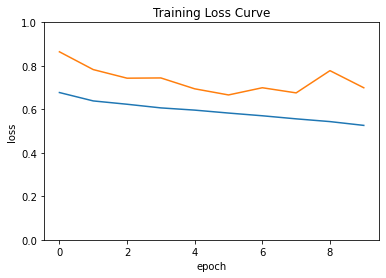

In [142]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel("loss")
plt.xlabel("epoch")
plt.title("Training Loss Curve")
plt.ylim([0,1])
plt.show()

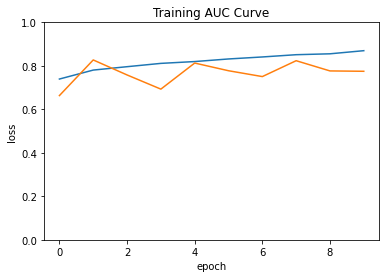

In [137]:
plt.plot(history.history['auc'])
plt.plot(history.history['val_auc'])
plt.ylabel("loss")
plt.xlabel("epoch")
plt.ylim([0,1])
plt.title("Training AUC Curve")
plt.show()

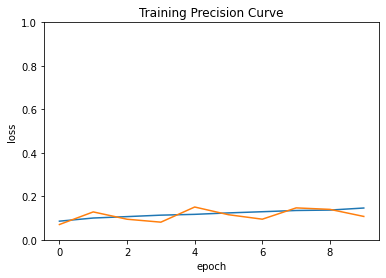

In [139]:
plt.plot(history.history['precision'])
plt.plot(history.history['val_precision'])
plt.ylabel("loss")
plt.xlabel("epoch")
plt.ylim([0,1])
plt.title("Training Precision Curve")
plt.show()

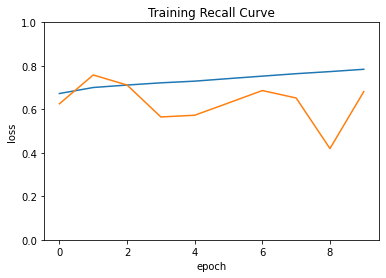

In [141]:
plt.plot(history.history['recall'])
plt.plot(history.history['val_recall'])
plt.ylabel("loss")
plt.xlabel("epoch")
plt.ylim([0,1])
plt.title("Training Recall Curve")
plt.show()

In [144]:
import random
import matplotlib.pyplot as plt
random.seed()

import numpy as np
from sklearn.metrics import roc_auc_score, roc_curve


def get_roc_curve(labels, predicted_vals, generator):
    auc_roc_vals = []
    for i in range(len(labels)):
        try:
            y_true = generator.labels[:,i]
            y_pred = predicted_vals[:,i]
            auc_roc = roc_auc_score(y_true, y_pred)
            auc_roc_vals.append(auc_roc)
            fpr, tpr, _ = roc_curve(y_true, y_pred)
            
            plt.figure(1,figsize=(10,10))
            plt.plot([0,1],[0,1], 'k--')
            plt.plot(fpr, tpr,
                     label=labels[i] + " (" + str(round(auc_roc, 3)) + ")")
            plt.xlabel("False positive rate")
            plt.ylabel("True positive rate")
            plt.title("ROC curve")
            plt.legend(loc="best")
        except:
            print(
                f"Error in generating ROC curve for {labels[i]}."
                f"Dataset lacks enough examples.")
    plt.show()
    return auc_roc_vals

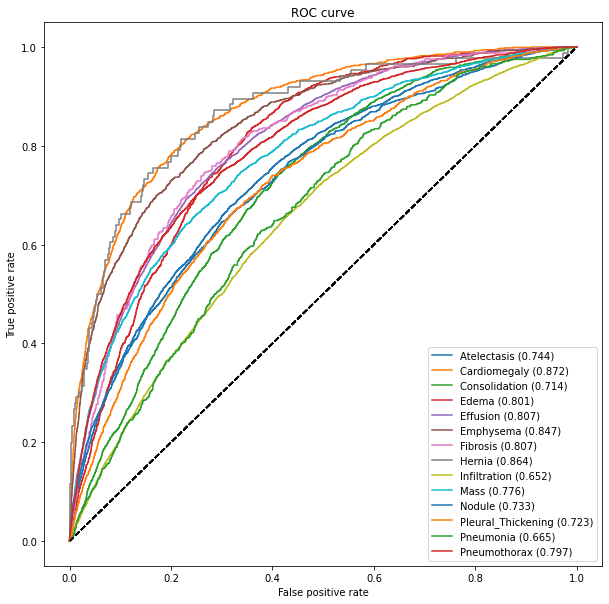

[0.7435090141097168,
 0.8719380215301189,
 0.7142595722237224,
 0.8008597466989911,
 0.8066029740179157,
 0.8465800386150599,
 0.806648859505703,
 0.8643924407209211,
 0.6515267494284477,
 0.7757971778932476,
 0.7329660943525526,
 0.7232696365863931,
 0.6647093721252102,
 0.7970300410980884]

In [145]:
get_roc_curve(labels=y_cols, predicted_vals=predicted_vals, generator=test_gen)